In [61]:
simpleCap <- function(x) {
  s <- strsplit(x, " ")[[1]]
  paste(toupper(substring(s, 1,1)), tolower(substring(s, 2)),
      sep="", collapse=" ")
}

In [3]:
#connect R to mysql
source('config.R')
library('RMySQL')
library('reshape2')
library('ggplot2')
childes_db = dbConnect(MySQL(), user=config[['username']], password=config[['password']], dbname=config[['dbasename']], host=config[['host']])

In [12]:
query = dbSendQuery(childes_db, "select gender, gloss, count(mor) from words where speaker != 'CHI' and gender != '' group by gender, gloss")

In [13]:
word_counts_per_gender = fetch(query, n=-1)

In [15]:
word_counts_per_gender[1:5,]

,gender,gloss,count(mor)
1,female,,1
2,female,&=imitlaughter,1
3,female,&=laughs,8
4,female,&=whistle,1
5,female,&a,4


In [16]:
names(word_counts_per_gender)[3] = 'count'

In [17]:
wcpg = do.call('rbind' , lapply(split(word_counts_per_gender, word_counts_per_gender$gender), function(df){
    df$probability =  df$count / sum(df$count)
    return(df)
}))

In [27]:
wc_m = subset(wcpg, gender =='male')
names(wc_m) = c('gender','gloss','m_count','m_probability')
wc_m$gender = NULL
wc_f = subset(wcpg, gender =='female')
names(wc_f) = c('gender','gloss','f_count','f_probability')
wc_f$gender = NULL
wc = merge(wc_m, wc_f)

In [62]:
wc$caps = sapply(wc$gloss, function(x){x == simpleCap(x)})

In [69]:
wc[1:5,]

,gloss,m_count,m_probability,f_count,f_probability,f_predict_m_resid,log_odds_m,caps
1,&=laughs,161,0.000182834,8,6.976724e-06,3.343195,26.20629,TRUE
2,&a,3,3.406845e-06,4,3.488362e-06,-0.07137626,0.9766319,TRUE
3,&ah,42,4.769584e-05,41,3.575571e-05,0.6598516,1.333936,TRUE
4,&aw,170,0.0001930546,172,0.0001499996,0.8824957,1.287034,TRUE
5,&ba,3,3.406845e-06,8,6.976724e-06,-0.6395966,0.4883159,TRUE


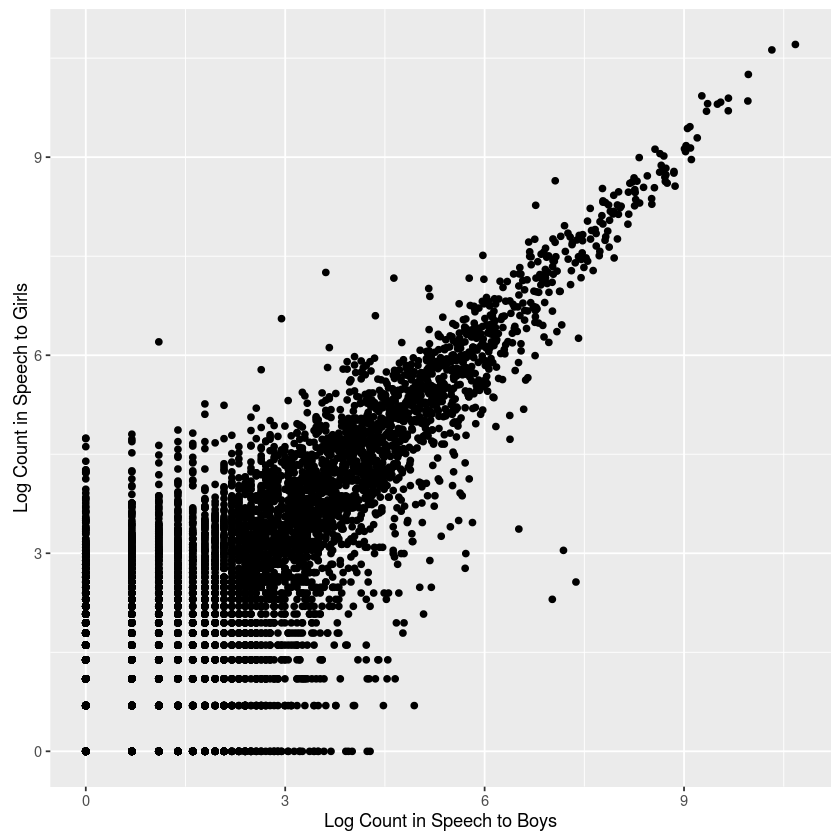

In [31]:
ggplot(wc) + geom_point(aes(x=log(m_count), y=log(f_count))) + xlab('Log Count in Speech to Boys') + ylab('Log Count in Speech to Girls')

In [51]:
f_predict_m = lm(log(m_probability) ~ log(f_probability), wc)
wc$f_predict_m_resid = f_predict_m$residuals

pdf 
  2

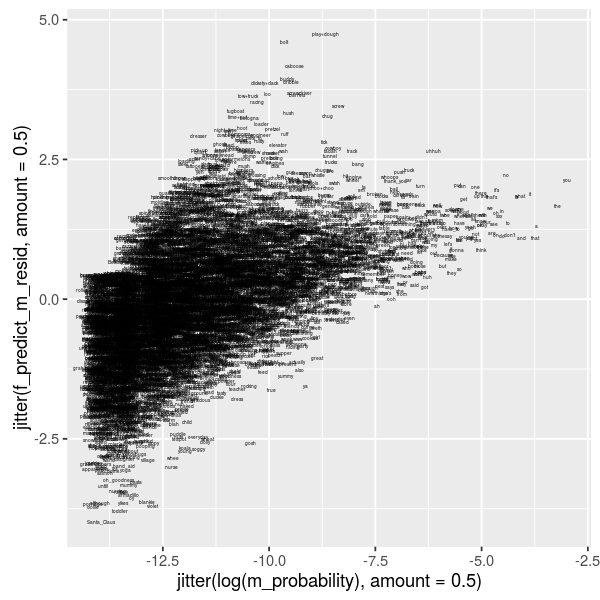

In [76]:
g1 = ggplot(subset(wc, !caps)) + geom_text(aes(x=jitter(log(m_probability), amount=.5), y=jitter(f_predict_m_resid, amount=.5), label=gloss),size=1)
pdf('male_predicted_by_female.pdf', width=20, height=20)
print(g1)
dev.off()
options(repr.plot.width=5, repr.plot.height=5, jupyter.plot_mimetypes = 'image/png')
print(g1)

In [49]:
wc$log_odds_m =  wc$m_probability / wc$f_probability
subset(wc, gloss %in% c('you','it','what','the','and'))

,gloss,m_count,m_probability,f_count,f_probability,f_predict_m_resid,log_odds_m
782,and,10590,0.01202616,20519,0.01789442,-0.006866439,0.6720621
3527,it,21165,0.02403529,18984,0.01655577,0.006556397,1.451778
6383,the,30376,0.03449545,41152,0.03588827,-0.003399764,0.9611901
6971,what,15766,0.01790411,16366,0.01427263,0.00283634,1.254436
7192,you,43266,0.04913353,44690,0.03897372,0.007979884,1.260683


In [77]:
m_predict_f = lm(log(f_probability) ~ log(m_probability), wc)
wc$m_predict_f_resid = m_predict_f$residuals

pdf 
  2

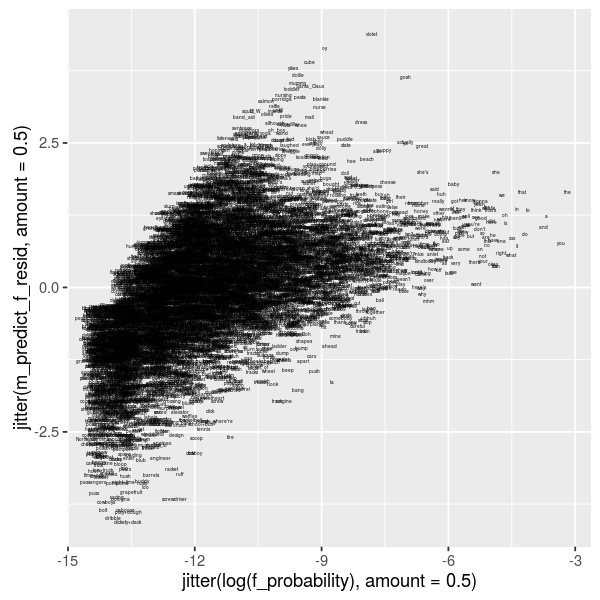

In [79]:
g1 = ggplot(subset(wc, !caps)) + geom_text(aes(x=jitter(log(f_probability), amount=.5), y=jitter(m_predict_f_resid, amount=.5), label=gloss),size=1)
pdf('female_predicted_by_male.pdf', width=20, height=20) + geom_hline(intercept = 0, color = )
print(g1)
dev.off()
options(repr.plot.width=5, repr.plot.height=5, jupyter.plot_mimetypes = 'image/png')
print(g1)